--- 
description: Here we show how to solve the graph partitioning problem using JijZept and JijModeling.
---

# Graph Partitioning

Here we show how to solve the graph partitioning problem using JijZept and [JijModeling](https://www.ref.documentation.jijzept.com/jijmodeling/). 
This problem is also mentioned in 2.2. Graph Partitioning on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full).

## What is Graph Partitioning?

Graph partitioning is the problem of dividing a graph into two subsets of equal size with the aim of minimizing the number of edges between the subsets.

### Example

Let us take a look at the following situation.
Consider a graph with 6 vertices labeled from 1 to 6, and edges connecting vertices as follows:
- 1 is connected to 2 and 3
- 2 is connected to 1, 3, and 4
- 3 is connected to 1 and 2
- 4 is connected to 2, 5, and 6
- 5 is connected to 4 and 6
- 6 is connected to 4 and 5

The goal is to partition this graph into two subsets of equal size (i.e., 3 vertices in each subset) with minimized edges between them.
In this case, the optimal solution is $\{1, 2, 3\}, \{4, 5, 6\}$, where there is only 1 edge connecting vertices in different subsets (i.e., the edge (2,4)), which is the minimum possible number of edges connecting the two subsets. 

![](./assets/11-graph_partitioning_1.png)




### Mathematical Model

Let $G=(V, E)$ be the undirected graph where $V$ is the set of vertices and $E$ is the set of edges.
The goal is to partition $V$ into two subsets $V_1$ and $V_2$ of equal size, with the number of edges crossing the partition being minimized.
We introduce variables $x_{u}$ which is 1 if vertex $u$ is in the subset $V_1$ and 0 if vertex $u$ is in the subset $V_2$.

**Constraint: the vertices must be partitioined into two equal-sized sets**

We express this constraint as follows:

$$
∑_{u \in V} x_u = V/2 \tag{1}
$$

**Objective function: minimize the number of edges crossing the partition**

$$
\min \quad 
\sum_{(uv) \in E} (\{x_{u} (1-x_{v})\}+\{(1-x_{u}) x_{v}\})
 \tag{2}
$$

Here, the first term $x_u (1 - x_v)$ evaluates to 1 if edge (u, v) crosses the boundary between $V_1$ and $V_2$ (i.e., if $u$ belongs to $V_2$ and $v$ belongs to $V_1$), and 0 otherwise. Similarly, the second term $(1 - x_u) x_v$ evaluates to 1 if edge (u, v) crosses the boundary between $V_1$ and $V_2$ (i.e., if $u$ belongs to $V_1$ and $v$ belongs to $V_2$), and 0 otherwise.

Thus, this objective function is an indicator of how much graph partitioning has been achieved.

## Modeling by JijModeling

Next, we show an implementation using JijModeling. We first define variables for the mathematical model described above.

In [1]:
import jijmodeling as jm

# define variables
V = jm.Placeholder('V')
E = jm.Placeholder('E', ndim=2)
x = jm.BinaryVar('x', shape=(V,))
u = jm.Element('u', belong_to=V)
e = jm.Element('e', belong_to=E)

`V=jm.Placeholder('V')` represents the number of vertices. 
We denote `E=jm.Placeholder('E', ndim=2)` as a set of edges.
Then, we define a list of binary variables `x=jm.BinaryVar('x', shape=(V,))`, and we set the subscripts `u` used in the mathematical model.
Finally, `e` represents the variable for edges. `e[0]` and `e[1]` represent the two vertices connected by the edge.

### Constraint

We implement a constraint Equation (1).

In [2]:
# set problem
problem = jm.Problem('Graph Partitioning')
# set constraint: the vertices must be partitioined into two equal-sized sets
const = jm.sum(u, x[u])
problem += jm.Constraint('constraint', const==V/2)

### Objective function

Next, we implement an objective function Equation (2).

In [3]:
# set objective function: minimize the number of edges crossing the partition
A_1 = x[e[0]]*(1-x[e[1]])
A_2 = (1-x[e[0]])*x[e[1]]
problem += jm.sum(e, (A_1 + A_2))

Let's display the implemented mathematical model in Jupyter Notebook.

In [4]:
problem

## Prepare an instance

We prepare a graph using [NetworkX](https://networkx.org/). 
Here we create random graph with 12 vertices.

In [19]:
import networkx as nx

# set the number of vertices
inst_V = 12
# create a random graph
inst_G = nx.gnp_random_graph(inst_V, 0.4)
# get information of edges
inst_E = [list(edge) for edge in inst_G.edges]
instance_data = {'V': inst_V, 'E': inst_E}

## Solve by JijZept's SA

We solve this problem using JijZept `JijSASampler`. We also use the parameter search function by setting `search=True`.

In [20]:
import jijzept as jz

# set sampler
config_path = "./config.toml"
sampler = jz.JijSASampler(config=config_path)
# solve problem
multipliers = {"constraint": 0.5}
results = sampler.sample_model(problem, instance_data, multipliers, num_reads=100, search=True)

## Visualize the solution

In the end, we extract the lowest energy solution from the feasible solutions and visualize it.

Objective: 7.0


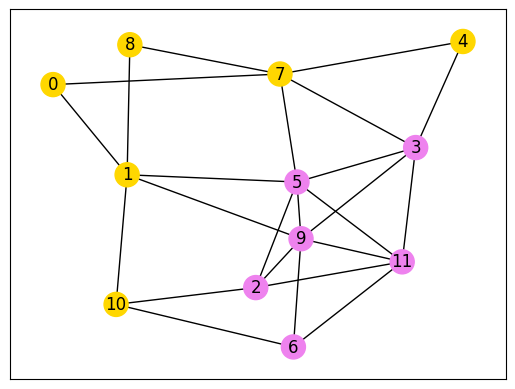

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# extract feasible solution
feasibles = results.feasible()
if feasibles.evaluation.objective.size == 0:
    print('No feasible solution found ...')
else:
    objectives = np.array(feasibles.evaluation.objective)
    lowest_index = np.argmin(objectives)
    print("Objective: "+str(feasibles.evaluation.objective[lowest_index]))
    # get vertices
    vertices, _, len_ = feasibles.record.solution['x'][lowest_index]
    # set color list for visualization
    colorlist = ['gold', 'violet']
    # initialize vertex color list
    node_colors = ['gold'] * len_[0]
    # set vertex color list
    for i in vertices[0]:
        node_colors[i] = colorlist[1]
    # make figure
    nx.draw_networkx(inst_G, node_color=node_colors, with_labels=True)
    plt.show()

With the above visualization, we obtain a feasible partitioning for this graph.